In [1]:
import pandas as pd
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import os

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

In [2]:
DATASET_PATH = 'GTZAN'

def list_audio_files(dataset_path):
    files = []
    genres = []
    for genre_dir in sorted(os.listdir(dataset_path)):
        genre_path = os.path.join(dataset_path, genre_dir)
        if os.path.isdir(genre_path):
            # wavs = glob.glob(os.path.join(genre_path, '*.wav'))
            wavs = glob.glob(os.path.join(genre_path, '*.au'))

            for w in wavs:
                files.append(w)
                genres.append(genre_dir)
    return pd.DataFrame({'path':files, 'genre':genres})

df = list_audio_files(DATASET_PATH)
print(len(df))
df.head()                

1000


,path,genre
0,GTZAN\blues\blues.00000.au,blues
1,GTZAN\blues\blues.00001.au,blues
2,GTZAN\blues\blues.00002.au,blues
3,GTZAN\blues\blues.00003.au,blues
4,GTZAN\blues\blues.00004.au,blues


In [3]:
def extract_mfcc_features(file_path, n_mfcc=20, sr=22050, duration=30):
    y,_ = librosa.load(file_path, sr=sr, duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)
    features = np.concatenate([mfcc_mean, mfcc_std])
    return features
features_list = []
for i, row in df.iterrows():
    feats = extract_mfcc_features(row['path'])
    features_list.append(feats)

x_mfcc = np.vstack(features_list)
y = df['genre'].values
print(x_mfcc.shape)    

(1000, 40)


In [4]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

scalar = StandardScaler()
x_mfcc_scalar = scalar.fit_transform(x_mfcc)
x_train, x_test, y_train, y_test = train_test_split(x_mfcc_scalar, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
print(x_train.shape,
x_test.shape)

(800, 40) (200, 40)


In [5]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

0.655
              precision    recall  f1-score   support

       blues       0.65      0.65      0.65        20
   classical       0.80      1.00      0.89        20
     country       0.63      0.60      0.62        20
       disco       0.40      0.30      0.34        20
      hiphop       0.64      0.70      0.67        20
        jazz       0.83      0.75      0.79        20
       metal       0.67      0.80      0.73        20
         pop       0.78      0.90      0.84        20
      reggae       0.60      0.60      0.60        20
        rock       0.36      0.25      0.29        20

    accuracy                           0.66       200
   macro avg       0.64      0.66      0.64       200
weighted avg       0.64      0.66      0.64       200



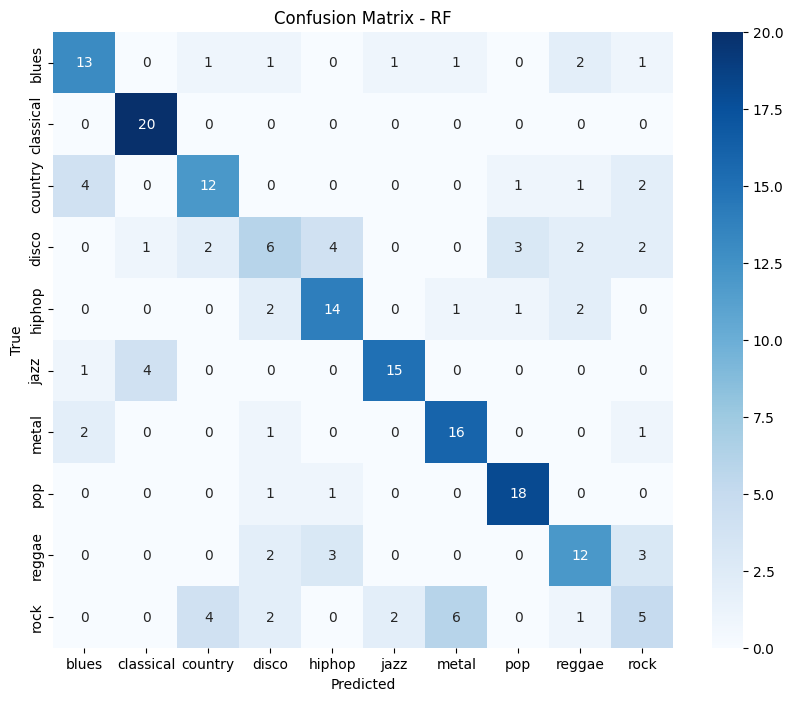

In [6]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RF')
plt.show()

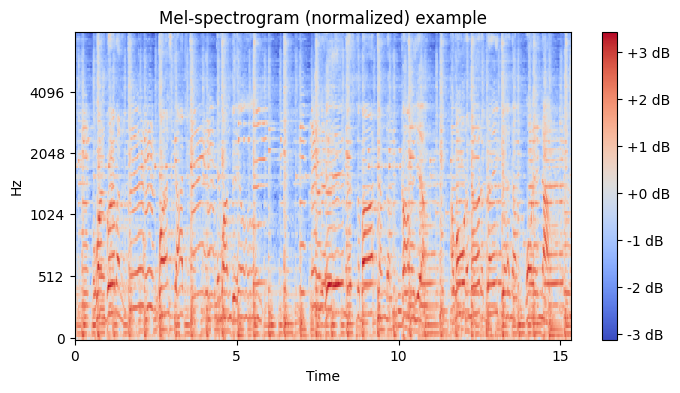

In [13]:
def extract_me_spectrogram(file_path, sr=22050, n_mels=128, fmax=8000, duration=30, max_len=660):
    y,_ = librosa.load(file_path, sr=sr, duration=duration)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-9)

    # Pad or truncate along the time axis
    if S_db_norm.shape[1] < max_len:
        pad_width = max_len - S_db_norm.shape[1]
        S_db_norm = np.pad(S_db_norm, ((0,0), (0,pad_width)), mode='constant')
    else:
        S_db_norm = S_db_norm[:, :max_len]

    return S_db_norm.astype(np.float32)

example_path = df['path'].iloc[0]
spec = extract_me_spectrogram(example_path)
plt.figure(figsize=(8,4))
librosa.display.specshow(spec, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram (normalized) example')
plt.show()

In [14]:
SAMPLES = []
LABELS = []
for i, row in df.iterrows():
    spec = extract_me_spectrogram(row["path"], max_len=660)
    SAMPLES.append(spec)
    LABELS.append(row["genre"])

SAMPLES = np.array(SAMPLES)  # now shape: (1000, 128, 660)
print("Raw SAMPLES shape:", SAMPLES.shape)

# Add channel dimension
SAMPLES = SAMPLES[..., np.newaxis]  # (1000, 128, 660, 1)

# Encode labels
le = LabelEncoder()
y_cnn = le.fit_transform(LABELS)
y_cnn = utils.to_categorical(y_cnn, num_classes=len(le.classes_))

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    SAMPLES, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn
)
print("CNN train/test shapes:", X_train_c.shape, X_test_c.shape)


Raw SAMPLES shape: (1000, 128, 660)
CNN train/test shapes: (800, 128, 660, 1) (200, 128, 660, 1)


In [15]:
# 5B. Simple CNN model (small architecture)
input_shape = X_train_c.shape[1:]  # (n_mels, time_frames, 1)

def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2,2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = y_train_c.shape[1]
model = build_cnn(input_shape, num_classes)
model.summary()


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 660, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 660, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 330, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 330, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 330, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 165, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 165, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 165, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 82, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train_c, y_train_c, validation_split=0.15, epochs=50, batch_size=16, callbacks=[es], verbose=1)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.3015 - loss: 1.9740 - val_accuracy: 0.1000 - val_loss: 2.3125
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4000 - loss: 1.6084 - val_accuracy: 0.1000 - val_loss: 2.5336
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.4926 - loss: 1.4594 - val_accuracy: 0.1083 - val_loss: 2.8842
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.5338 - loss: 1.3345 - val_accuracy: 0.1250 - val_loss: 4.0271
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.5912 - loss: 1.2437 - val_accuracy: 0.1583 - val_loss: 4.7333
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5971 - loss: 1.1322 - val_accuracy: 0.1583 - val_loss: 4.7856
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.6088 - loss: 1.1191 - val_accuracy: 0.1417 - val_loss: 5.1648


0.100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.10      1.00      0.18        20
     country       0.00      0.00      0.00        20
       disco       0.00      0.00      0.00        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.00      0.00      0.00        20
       metal       0.00      0.00      0.00        20
         pop       0.00      0.00      0.00        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.10       200
   macro avg       0.01      0.10      0.02       200
weighted avg       0.01      0.10      0.02       200



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

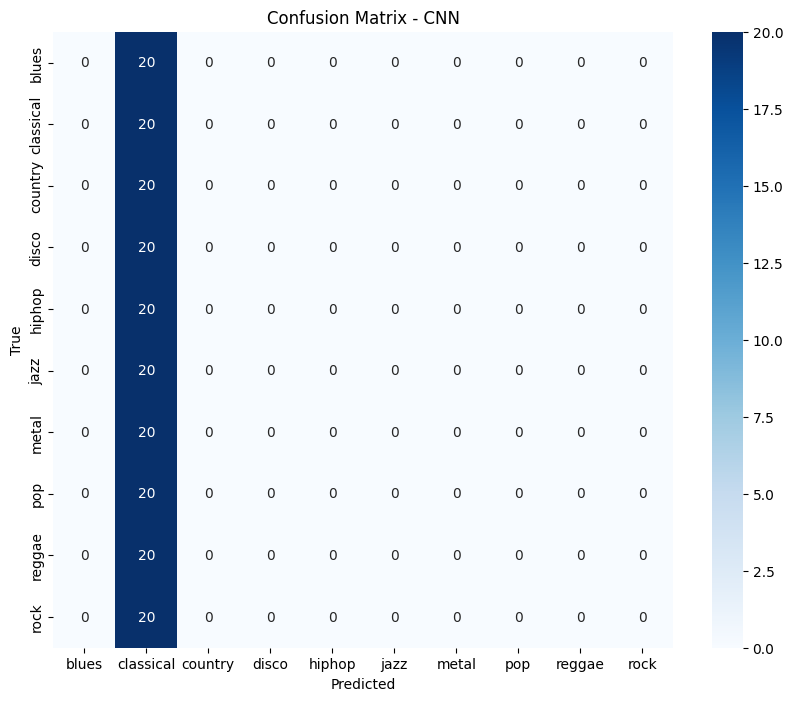

In [17]:
test_loss, test_acc = model.evaluate(X_test_c,y_test_c, verbose=0)
print(f'{test_acc:.3f}')
y_pred_probs = model.predict(X_test_c)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_c, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

def prepare_spectrogram_for_tl(spec, target_size=(224,224)):
    spec_resized = cv2.resize(spec, target_size)
    spec_resized = (spec_resized-spec_resized.min())/(spec_resized.max() - spec_resized.min()+1e-9)*225
    spec_rgb = np.stack([spec_resized]*3, axis=-1)
    return spec_rgb.astype(np.uint8)

SAMPLES_TL = []
for spec in SAMPLES[..., 0]:
    SAMPLES_TL.append(prepare_spectrogram_for_tl(spec))

SAMPLES_TL = np.array(SAMPLES_TL)
print(SAMPLES_TL.shape) 

SAMPLES_TL = preprocess_input(SAMPLES_TL)
x_train_tl, x_test_tl, y_train_tl, y_test_tl = train_test_split(SAMPLES_TL, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn)

(1000, 224, 224, 3)


In [22]:
# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model layers (fine-tuning optional later)
for layer in base_model.layers:
    layer.trainable = False

# Build custom head
inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_tl = models.Model(inputs, outputs)
model_tl.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_tl.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 45s 5us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Add data augmentation for spectrogram "images"
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

history_tl = model_tl.fit(
    datagen.flow(x_train_tl, y_train_tl, batch_size=16),
    validation_data=(x_test_tl, y_test_tl),
    epochs=30,
    callbacks=[es],
    verbose=1
)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 674ms/step - accuracy: 0.3162 - loss: 1.9804 - val_accuracy: 0.4400 - val_loss: 1.5349
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.4425 - loss: 1.5734 - val_accuracy: 0.5800 - val_loss: 1.2968
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - accuracy: 0.5225 - loss: 1.4048 - val_accuracy: 0.5850 - val_loss: 1.3031
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 628ms/step - accuracy: 0.5462 - loss: 1.3073 - val_accuracy: 0.5350 - val_loss: 1.3081
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 682ms/step - accuracy: 0.5587 - loss: 1.2668 - val_accuracy: 0.6200 - val_loss: 1.1565
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.5612 - loss: 1.2175 - val_accuracy: 0.6150 - val_loss: 1.2076
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step - accuracy: 0.5850 - loss: 1.1808 - val_accuracy: 0.5700 - val_loss: 1.2539
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.6062 - loss: 1.1252 - val_accu

In [25]:
# Evaluate
test_loss, test_acc = model_tl.evaluate(x_test_tl, y_test_tl, verbose=0)
print(f"Transfer Learning (MobileNetV2) Test Accuracy: {test_acc:.3f}")

# Classification Report
y_pred_probs_tl = model_tl.predict(x_test_tl)
y_pred_labels_tl = np.argmax(y_pred_probs_tl, axis=1)
y_true_labels_tl = np.argmax(y_test_tl, axis=1)

print(classification_report(y_true_labels_tl, y_pred_labels_tl, target_names=le.classes_))


Transfer Learning (MobileNetV2) Test Accuracy: 0.660
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 866ms/step
              precision    recall  f1-score   support

       blues       1.00      0.30      0.46        20
   classical       0.86      0.95      0.90        20
     country       0.50      0.50      0.50        20
       disco       0.65      0.65      0.65        20
      hiphop       0.60      0.75      0.67        20
        jazz       0.85      0.85      0.85        20
       metal       0.81      0.85      0.83        20
         pop       0.54      0.65      0.59        20
      reggae       0.60      0.75      0.67        20
        rock       0.41      0.35      0.38        20

    accuracy                           0.66       200
   macro avg       0.68      0.66      0.65       200
weighted avg       0.68      0.66      0.65       200



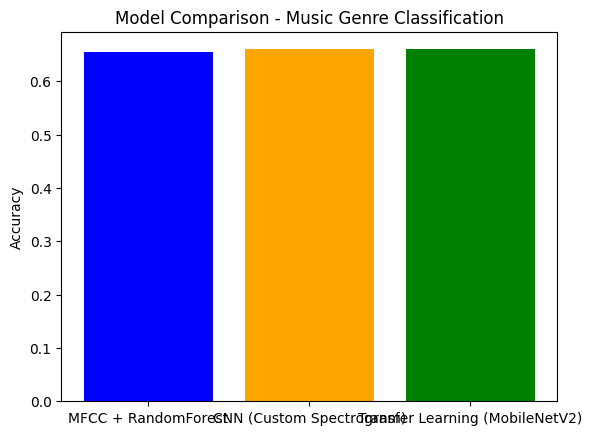

MFCC + RandomForest: 0.655
CNN (Custom Spectrogram): 0.660
Transfer Learning (MobileNetV2): 0.660


In [26]:
results = {
    "MFCC + RandomForest": accuracy_score(y_test, y_pred_rf),
    "CNN (Custom Spectrogram)": test_acc,   # from earlier CNN model
    "Transfer Learning (MobileNetV2)": test_acc
}

plt.bar(results.keys(), results.values(), color=["blue","orange","green"])
plt.ylabel("Accuracy")
plt.title("Model Comparison - Music Genre Classification")
plt.show()

for k,v in results.items():
    print(f"{k}: {v:.3f}")
